In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호 깨짐 방지

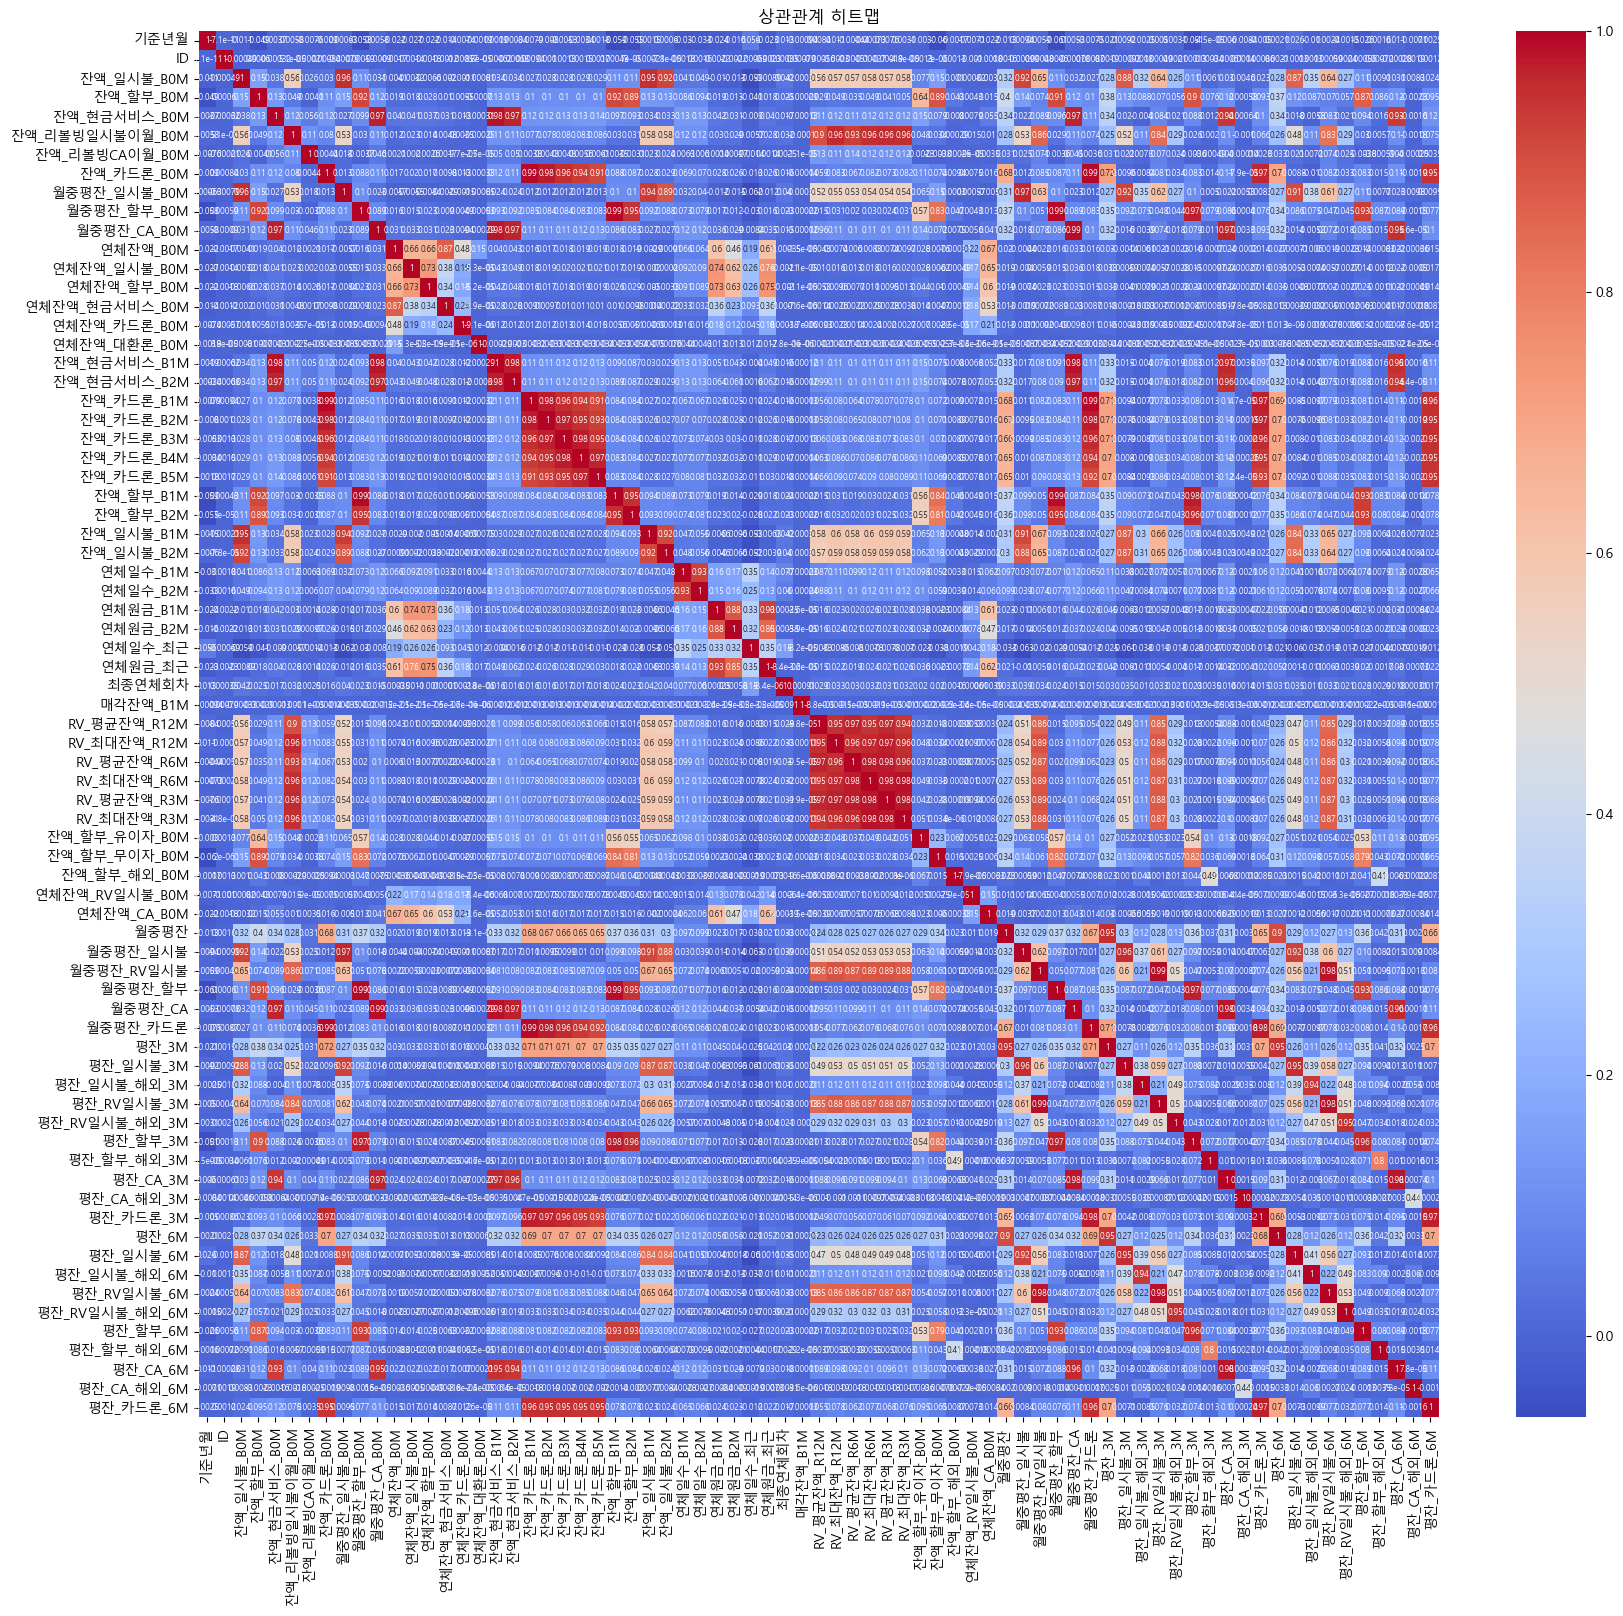

In [6]:
# 상관관계 분석 시각화

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 데이터 load
df = pd.read_parquet("open/train/5.잔액정보/잔액정보 월별 합본_전처리.parquet")

# 복사본 생성
df_corr = df.copy()

# Label Encoding
for col in df_corr.select_dtypes(include=['object', 'category']).columns:
    df_corr[col] = LabelEncoder().fit_transform(df_corr[col].astype(str))

# float64 → float32 변환
for col in df_corr.select_dtypes(include='float64').columns:
    df_corr[col] = df_corr[col].astype('float32')

# int64 → int32 변환
for col in df_corr.select_dtypes(include='int64').columns:
    df_corr[col] = df_corr[col].astype('int32')

# 상관관계 행렬 계산
corr_matrix = df_corr.corr()

# 시각화 (옵션)
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.title("상관관계 히트맵")
plt.show()

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df_corr.select_dtypes(include='number').dropna()

X_const = add_constant(X)

# VIF
vif_df = pd.DataFrame()
vif_df["변수명"] = X_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

vif_df = vif_df.sort_values("VIF", ascending=False)
print(vif_df)

C:\Users\dlxod\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


KeyboardInterrupt: 

In [6]:
import numpy as np
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_corr.select_dtypes(include='number')
X = X.loc[:, X.nunique() > 1]  # 변동 없는 열 제거
X = X.dropna()
X_const = add_constant(X)

vif_values = []
for i in range(X_const.shape[1]):
    try:
        vif = variance_inflation_factor(X_const.values, i)
    except Exception:
        vif = np.nan
    vif_values.append(vif)

vif_df = pd.DataFrame({
    "변수명": X_const.columns,
    "VIF": vif_values
}).sort_values("VIF", ascending=False)

print(vif_df)

C:\Users\dlxod\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


KeyboardInterrupt: 

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import pandas as pd

X = df_corr.select_dtypes(include='number')
X = X.loc[:, X.nunique() > 1]  # 변동이 없는 열 제거
X = X.dropna()

X_const = add_constant(X)

vif_list = []
problem_vars = []

for i in range(X_const.shape[1]):
    var_name = X_const.columns[i]
    try:
        vif = variance_inflation_factor(X_const.values, i)
    except Exception as e:
        vif = np.nan
        problem_vars.append((var_name, str(e)))
    vif_list.append(vif)

vif_df = pd.DataFrame({
    "변수명": X_const.columns,
    "VIF": vif_list
}).sort_values("VIF", ascending=False)

print("VIF 결과:")
print(vif_df)

if problem_vars:
    print("\n오류 발생 변수 및 이유:")
    for var, reason in problem_vars:
        print(f"{var}: {reason}")

VIF 결과:
            변수명  VIF
0         const  NaN
1          기준년월  NaN
2            ID  NaN
3    잔액_일시불_B0M  NaN
4     잔액_할부_B0M  NaN
..          ...  ...
69     평잔_할부_6M  NaN
70  평잔_할부_해외_6M  NaN
71     평잔_CA_6M  NaN
72  평잔_CA_해외_6M  NaN
73    평잔_카드론_6M  NaN

[74 rows x 2 columns]

오류 발생 변수 및 이유:
const: Unable to allocate 1.32 GiB for an array with shape (2400000, 74) and data type float64
기준년월: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
ID: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_일시불_B0M: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_할부_B0M: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_현금서비스_B0M: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_리볼빙일시불이월_B0M: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_리볼빙CA이월_B0M

In [8]:
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant

# 수치형 열만 선택
X = df_corr.select_dtypes(include='number')
X = X.loc[:, X.nunique() > 1].dropna()  # 상수열 제거, 결측 제거

problem_cols = []

for target_col in X.columns:
    try:
        y = X[target_col]
        X_others = X.drop(columns=[target_col])
        X_others_const = add_constant(X_others)

        model = OLS(y, X_others_const).fit()
        r2 = model.rsquared

        # R² == 1 또는 TSS가 거의 0이면 문제로 판단
        if np.isclose(r2, 1.0) or np.isclose(np.var(y), 0):
            problem_cols.append((target_col, r2))
    except Exception as e:
        problem_cols.append((target_col, f"Error: {e}"))

# 결과 출력
print("🔍 VIF ∞ 또는 divide by zero 유발 가능성이 있는 열:")
for col, r2 in problem_cols:
    print(f"{col}: R² = {r2}")

🔍 VIF ∞ 또는 divide by zero 유발 가능성이 있는 열:
기준년월: R² = Error: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
ID: R² = Error: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_일시불_B0M: R² = Error: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_할부_B0M: R² = Error: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_현금서비스_B0M: R² = Error: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_리볼빙일시불이월_B0M: R² = Error: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_리볼빙CA이월_B0M: R² = Error: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
잔액_카드론_B0M: R² = Error: Unable to allocate 1.31 GiB for an array with shape (2400000, 73) and data type float64
월중평잔_일시불_B0M: R² = Error: Unable to allocate 1.31 GiB for an array w